## Project 5: WAM News Prediction of California's Gubernatorial 2021 Election

## Imports
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

import random
random.seed(42)

import warnings
warnings.filterwarnings("ignore")

### Functions
---

In [2]:
def class_metrics(X_train, y_train, X_test, y_test, model):
    """
    This Function takes in X, and y train 
    test data and prints out three metrics
    that we want to optimize for.
    """
    #Training metrics
    y_preds_train = model.predict(X_train)
    sens_tr = recall_score(y_train, y_preds_train, pos_label=1)
    spec_tr = recall_score(y_train, y_preds_train, pos_label=0)
    prec_tr = precision_score(y_train, y_preds_train)
    train_acc = model.score(X_train, y_train)
    
    #Test metrics
    y_preds_test = model.predict(X_test)
    sens_tst = recall_score(y_test, y_preds_test, pos_label=1)
    spec_tst = recall_score(y_test, y_preds_test, pos_label=0)
    prec_tst = precision_score(y_test, y_preds_test)
    test_acc = model.score(X_test , y_test)
    
    print('Train Accuracy - Correctly Classified:', round(train_acc,8))
    print('Test Accuracy - Correctly Classified:', round(test_acc,8))
    
    print('\nTrain Sensitivity - True Positvive Rate:', round(sens_tr,8))
    print('Test Sensitivity - True Positvive Rate:', round(sens_tst,8))
    
    print('\nTrain Specificity - True Negative Rate:', round(spec_tr,8))
    print('Test Specificity - True Negative Rate:', round(spec_tst,8))
    
    print('\nTrain Precision:', round(prec_tr,8))
    print('Test Precision:', round(prec_tst,8))
    
    print('\nConfusion Matrix of Test Data')
    plot_confusion_matrix(model, X_test, y_test, cmap='BuPu', values_format='d')

### Modeling
---

In [3]:
#Read in csv of feature selected from EDA notbook.
df = pd.read_csv('../Data/2018_gov_features.csv', index_col='Unnamed: 0')

#Dropping two features which we will include in our further iterations.
df.drop(columns=['ownhome', 'pid3'], inplace=True)
df.head()

,dist,gender,age,educ,race,faminc,marstat,newsint,approval_gov,ideo5,voted_gov
392782,19,Female,54,4-Year,White,50k - 60k,Single / Never Married,Most of the time,Strongly Approve,Liberal,[Democrat / Candidate 1]
392786,52,Female,28,Some College,White,20k - 30k,Single / Never Married,Most of the time,Strongly Approve,Liberal,[Democrat / Candidate 1]
392800,49,Male,86,Post-Grad,White,120k - 150k,Widowed,Most of the time,Strongly Disapprove,Very Conservative,[Republican / Candidate 2]
392832,36,Male,80,Some College,White,20k - 30k,Widowed,Most of the time,Strongly Disapprove,Conservative,[Republican / Candidate 2]
392860,36,Male,83,4-Year,White,Prefer not to say,Married,Most of the time,Strongly Disapprove,Conservative,[Republican / Candidate 2]


#### Feature Engineer The Target Column.

Well define our target to be the 'voted_gov' column. well have to engineer this feature for modeling.

In [4]:
# Value counts funtion shows we have more then 2 options for our target.
df['voted_gov'].value_counts()

[Democrat / Candidate 1]       2287
[Republican / Candidate 2]     1376
I Did Not Vote In This Race      37
Not Sure                         25
Other                            14
Name: voted_gov, dtype: int64

In [5]:
# Drop the other, not sure, and I did not vote classes in this race.
df = df[(df['voted_gov'] == '[Democrat / Candidate 1]') | (df['voted_gov'] == '[Republican / Candidate 2]')]

After some debate whether to encode the non Republican or Democrat catagroies and include in our target, we decided to drop them. The reasoning for this is that these categories represent around 3% of our target data, we feel that this is a heavily underrepresented class and our classification models wouldn't be able to classify them with any accuracy. Also, the purpose of this project is to accurately predict whether a Republican or Democrat would win the election we don't see these votes having an effect on our classification.

In [6]:
# Catagorize our Target column to have the voted for democrat to be our positive class.
df['voted_gov'] = df['voted_gov'].map({'[Democrat / Candidate 1]': 1, '[Republican / Candidate 2]': 0})

# Relabling our target colum to signify the positive class is voting republican.
df.rename(columns={'voted_gov': 'voted_democrat'}, inplace=True)

#### Dummify Catagorical Columns

In [7]:
# Use pd.get_dummies to dummify the catagoricalcolums.
df = pd.get_dummies(df, columns=['gender', 'educ', 'race', 'faminc', 'marstat', 'newsint', 'approval_gov','ideo5'], drop_first=True)

In [8]:
# Create X and y variables
X = df.drop(columns=['voted_democrat'])
y = df['voted_democrat']

# Create a train test split with a 30% test size.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Null Model
---
>For classification problems, we build our null model based on the most frequent value in the train data. We would use the shape of X_test to create array which will be predictions from the null model.

In [9]:
# which one is the most frequent value?
y_train.value_counts(normalize=True)

1    0.624317
0    0.375683
Name: voted_democrat, dtype: float64

In [10]:
# checkout X_test shape
X_test.shape

(916, 45)

In [11]:
# create an array of the most frequent value with number of rows equal to test data
# (this will be our null model predictions)
y_hat = np.ones(916)
y_hat[:5]

array([1., 1., 1., 1., 1.])

In [12]:
# classification report for the null model
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       344
           1       0.62      1.00      0.77       572

    accuracy                           0.62       916
   macro avg       0.31      0.50      0.38       916
weighted avg       0.39      0.62      0.48       916



Our Null model has an accuracy of 62% this will be the model that our models will have to beat.

### Grid Search: Logistic Regression / Knn / Niave Bayes
---

Performed Gridsearches on three diifferent models, (Logistic Regression, KNN Classifer, and Naive Bayes). We will do some hpyer parameter turning and find the best hyperparameters to improve our metrics. We took those hyperparameters added them to our final voting classifer,to create an ensemble learning model. Perhapes, if the models where interpretable more value could be gained from their interpretation.

In [13]:
# Scale our data for a logistic regression model
lr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression()),
])

# Find the optimal hyperparameters.
pipe_params ={
    'lr__C' : [1.0, 0.1, 0.01, 0.001],
    'lr__penalty': ['l1','l2','none'],

}

# Gridsearch using the specified hyper parameters.
grid_model = GridSearchCV(
    lr_pipe,
    pipe_params,
    cv = 5,
    n_jobs = -1,
    verbose = 2
)

# Fit our training data to the Grisearch.
grid_model.fit(X_train, y_train)
print(grid_model.best_params_)
print(grid_model.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'lr__C': 0.1, 'lr__penalty': 'l2'}
Pipeline(steps=[('ss', StandardScaler()), ('lr', LogisticRegression(C=0.1))])


Train Accuracy - Correctly Classified: 0.92428103
Test Accuracy - Correctly Classified: 0.90502183

Train Sensitivity - True Positvive Rate: 0.9516035
Test Sensitivity - True Positvive Rate: 0.9458042

Train Specificity - True Negative Rate: 0.87887597
Test Specificity - True Negative Rate: 0.8372093

Train Precision: 0.928856
Test Precision: 0.90619765

Confusion Matrix of Test Data


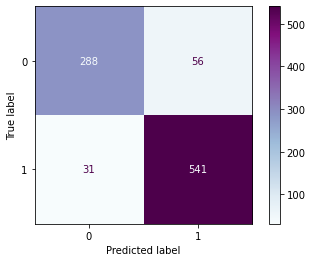

In [14]:
class_metrics(X_train, y_train, X_test,y_test, grid_model)

These results seem very good starting out, not very overfit, due to regularization, as well as very good sinsitivity 95%. lets try KNN and see the results imporve the goal is to have a voting classifer using three interpretable models.

In [15]:
# Create a pipleline to scale our data fro KNN Classification.
lr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier()),
])


# find the optimal hyperparameters.
pipe_params ={
    'knn__n_neighbors' : [1 ,2, 3, 4, 5, 6, 7],
}

# Create a gridsearch model to find our Hyperparameters
grid_model = GridSearchCV(
    lr_pipe,
    pipe_params,
    cv = 5,
    n_jobs = -1,
    verbose = 2
)


# Fit our training data to the Grisearch.
grid_model.fit(X_train, y_train)
print(grid_model.best_params_)
print(grid_model.best_estimator_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'knn__n_neighbors': 7}
Pipeline(steps=[('ss', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=7))])


Train Accuracy - Correctly Classified: 0.89807062
Test Accuracy - Correctly Classified: 0.84934498

Train Sensitivity - True Positvive Rate: 0.93411079
Test Sensitivity - True Positvive Rate: 0.90559441

Train Specificity - True Negative Rate: 0.83817829
Test Specificity - True Negative Rate: 0.75581395

Train Precision: 0.90559638
Test Precision: 0.86046512

Confusion Matrix of Test Data


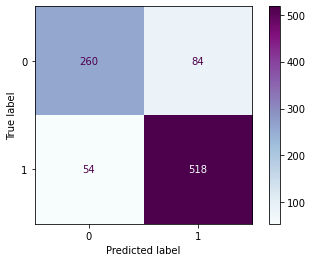

In [16]:
class_metrics(X_train, y_train, X_test,y_test, grid_model)

In the above KNN model. The Train-Test accuracy spread of 90% and 85% seem to show some overfitting and a lot of misclassification in predicting the negative class. we will now run a Naive Bayes model and evaluate the results.

In [17]:
# find the optimal hyperparameters.
grid_params ={
    'alpha': list(np.linspace(0.0, 1.0, num=5)),
    'fit_prior': [True, False]
}

# Fit our training data to the Grisearch.
grid_model = GridSearchCV(
    MultinomialNB(),
    grid_params,
    cv = 5,
    n_jobs = -1,
    verbose = 2
)

# Fit our training data to the Grisearch.
grid_model.fit(X_train, y_train)
print(grid_model.best_params_)
print(grid_model.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'alpha': 0.25, 'fit_prior': True}
MultinomialNB(alpha=0.25)


Train Accuracy - Correctly Classified: 0.86712778
Test Accuracy - Correctly Classified: 0.87882096

Train Sensitivity - True Positvive Rate: 0.89271137
Test Sensitivity - True Positvive Rate: 0.91608392

Train Specificity - True Negative Rate: 0.8246124
Test Specificity - True Negative Rate: 0.81686047

Train Precision: 0.8942757
Test Precision: 0.89267462

Confusion Matrix of Test Data


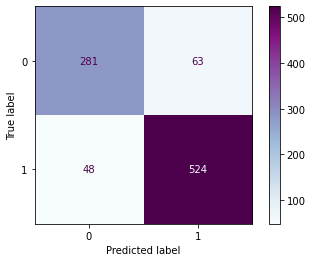

In [18]:
class_metrics(X_train, y_train, X_test,y_test, grid_model)

The Naive Bayes model shows an improvemnt in all metrics over the KNN model but still doesnt reach the 92/91% accuracy of the Logistic regression model

### Voting Classifer: Knn, Logistic Regression, MN Naive Bayes
___

In [19]:
#Knn scaled pipeline
knn_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=7))
])


#logistic regression scaled pipeline.
lr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(C=0.1, penalty='l2'))
])

#Create our voting classifer with knn
# logisitic regression, and MN Naive Bayes models.
vote = VotingClassifier([
    ('knn_pipe', knn_pipe),
    ('lr_pipe', lr_pipe),
    ('nb', MultinomialNB(alpha=0, fit_prior=True))
])

# Fit our training data to our Voting classifer.
vote.fit(X_train, y_train)

VotingClassifier(estimators=[('knn_pipe',
                              Pipeline(steps=[('ss', StandardScaler()),
                                              ('knn',
                                               KNeighborsClassifier(n_neighbors=7))])),
                             ('lr_pipe',
                              Pipeline(steps=[('ss', StandardScaler()),
                                              ('lr',
                                               LogisticRegression(C=0.1))])),
                             ('nb', MultinomialNB(alpha=0))])

Train Accuracy - Correctly Classified: 0.91700036
Test Accuracy - Correctly Classified: 0.89737991

Train Sensitivity - True Positvive Rate: 0.95102041
Test Sensitivity - True Positvive Rate: 0.94055944

Train Specificity - True Negative Rate: 0.86046512
Test Specificity - True Negative Rate: 0.8255814

Train Precision: 0.91887324
Test Precision: 0.89966555

Confusion Matrix of Test Data


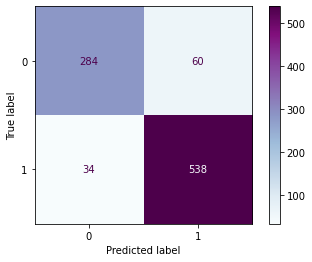

In [20]:
class_metrics(X_train, y_train, X_test,y_test, vote)

The Above voting classifer has improved all three of our metrics. Throughout this initial process we have had trouble imporving our sensitivity since our target class is unevenly balanced. We should note that our negative class those that vote democrat is 62% of our target, and our positive class vote republican, has 37% of our target data this value reflects the split of regestered democrats to republucan in the state of california. Lets see if adding more relivant features help our model better predict who will vote for each gubernatorial candidate.

### Lets include more relevant features to our model to improve performance.

To imporove our model we decided to incoorporate, home ownership, and party indentifier into our model to see it these would imporve our classification metrics.

In [21]:
# Including new feature dataframe, index is voter ID
df_2 = pd.read_csv('../Data/2018_gov_features.csv', index_col='Unnamed: 0')
df_2.head()

,dist,ownhome,pid3,gender,age,educ,race,faminc,marstat,newsint,approval_gov,ideo5,voted_gov
392782,19,Other,Democrat,Female,54,4-Year,White,50k - 60k,Single / Never Married,Most of the time,Strongly Approve,Liberal,[Democrat / Candidate 1]
392786,52,Rent,Democrat,Female,28,Some College,White,20k - 30k,Single / Never Married,Most of the time,Strongly Approve,Liberal,[Democrat / Candidate 1]
392800,49,Own,Other,Male,86,Post-Grad,White,120k - 150k,Widowed,Most of the time,Strongly Disapprove,Very Conservative,[Republican / Candidate 2]
392832,36,Own,Republican,Male,80,Some College,White,20k - 30k,Widowed,Most of the time,Strongly Disapprove,Conservative,[Republican / Candidate 2]
392860,36,Own,Independent,Male,83,4-Year,White,Prefer not to say,Married,Most of the time,Strongly Disapprove,Conservative,[Republican / Candidate 2]


In [22]:
# Only include those who voted for democrat or republican candadate.
df_2 = df_2[(df_2['voted_gov'] == '[Democrat / Candidate 1]') | (df_2['voted_gov'] == '[Republican / Candidate 2]')]

# Copy of clean dataframe for future interpretaion
# with a logistic regression model.
df_3 = df_2.copy()

In [23]:
# List of columns that will be dummified
cata_columns = ['dist', 'ownhome', 'pid3', 'gender', 'educ', 'race', 
                'faminc', 'marstat', 'newsint', 'approval_gov','ideo5']


# Dummify catagorical columns
df_2 = pd.get_dummies(df_2, columns=cata_columns, drop_first=True)

In [24]:
# Change the catagorical values in the target feature to "1" or "0" denoting a positive or negative class
df_2['voted_gov'] = df_2['voted_gov'].map({'[Democrat / Candidate 1]': 1, '[Republican / Candidate 2]': 0})

#Changing our target column to better indicate target: "voted_democrat"
df_2.rename(columns={'voted_gov': 'voted_democrat'}, inplace=True)

In [25]:
# Create X and y variables
X = df_2.drop(columns=['voted_democrat'])
y = df_2['voted_democrat']

# Train Test split our X and y Variables.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [26]:
# scale our data for a logistic regression model
lr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression()),
])

# find the optimal hyperparameters.
pipe_params ={
    'lr__C' : [1.0, 0.1, 0.01, 0.001],
    'lr__penalty': ['l1','l2','none'],

}

# Gridsearch using the specified hyper parameters.
grid_model = GridSearchCV(
    lr_pipe,
    pipe_params,
    cv = 5,
    n_jobs = -1,
    verbose = 2
)

# Fit our training data to the Grisearch.
grid_model.fit(X_train, y_train)
print(grid_model.best_params_)
print(grid_model.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'lr__C': 0.1, 'lr__penalty': 'l2'}
Pipeline(steps=[('ss', StandardScaler()), ('lr', LogisticRegression(C=0.1))])


Train Accuracy - Correctly Classified: 0.93847834
Test Accuracy - Correctly Classified: 0.92248908

Train Sensitivity - True Positvive Rate: 0.95918367
Test Sensitivity - True Positvive Rate: 0.95104895

Train Specificity - True Negative Rate: 0.90406977
Test Specificity - True Negative Rate: 0.875

Train Precision: 0.94323394
Test Precision: 0.92674617

Confusion Matrix of Test Data


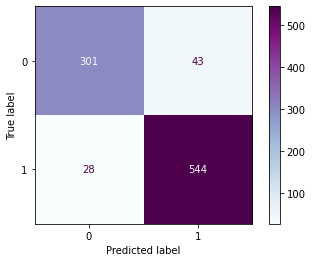

In [27]:
class_metrics(X_train, y_train, X_test,y_test, grid_model)

We can see above that compaired with our previous logistic Regression model, that adding our extra features caused our training data to be slighly more overfit, However this model classified the negative classes better. an imporvment of 3% points in specificity. 

In [28]:
# Create a pipleline to scale our data fro KNN Classification.
lr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier()),
])


# find the optimal hyperparameters.
pipe_params ={
    'knn__n_neighbors' : [1 ,2, 3, 4, 5, 6, 7],
}

# Create a gridsearch model to find our Hyperparameters
grid_model = GridSearchCV(
    lr_pipe,
    pipe_params,
    cv = 5,
    n_jobs = -1,
    verbose = 2
)


# Fit our training data to the Grisearch.
grid_model.fit(X_train, y_train)
print(grid_model.best_params_)
print(grid_model.best_estimator_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'knn__n_neighbors': 7}
Pipeline(steps=[('ss', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=7))])


Train Accuracy - Correctly Classified: 0.86530761
Test Accuracy - Correctly Classified: 0.81113537

Train Sensitivity - True Positvive Rate: 0.9271137
Test Sensitivity - True Positvive Rate: 0.90384615

Train Specificity - True Negative Rate: 0.7625969
Test Specificity - True Negative Rate: 0.65697674

Train Precision: 0.86648501
Test Precision: 0.81417323

Confusion Matrix of Test Data


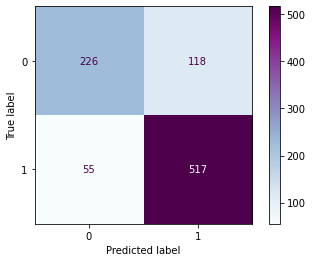

In [29]:
class_metrics(X_train, y_train, X_test,y_test, grid_model)

Adding the extra two features decreased our accuracy from 85% to 81% in our test set, with a slight imporovment to specificity. 66% to 75% in our test set.

In [30]:
# Listing our Naive Bayes hyperparameters.
grid_params ={
    'alpha': list(np.linspace(0.0, 1.0, num=5)),
    'fit_prior': [True, False]
}

# Fit our training data to the Grisearch.
grid_model = GridSearchCV(
    MultinomialNB(),
    grid_params,
    cv = 5,
    n_jobs = -1,
    verbose = 2
)

# Fit our training data to the Grisearch.
grid_model.fit(X_train, y_train)
print(grid_model.best_params_)
print(grid_model.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'alpha': 0.5, 'fit_prior': True}
MultinomialNB(alpha=0.5)


Train Accuracy - Correctly Classified: 0.9119039
Test Accuracy - Correctly Classified: 0.92358079

Train Sensitivity - True Positvive Rate: 0.92886297
Test Sensitivity - True Positvive Rate: 0.94405594

Train Specificity - True Negative Rate: 0.88372093
Test Specificity - True Negative Rate: 0.88953488

Train Precision: 0.92994746
Test Precision: 0.93425606

Confusion Matrix of Test Data


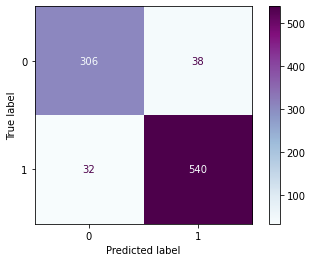

In [31]:
class_metrics(X_train, y_train, X_test,y_test, grid_model)

Adding the two new features increases our accuracy from 87% to ~91% of all the previous models adding these new features has increased our Naive Bayes model the most. Let us know put all of these models in a voting classifer and see how we cause each of these models in ensemble learning.

### Voting Classifer with Added Features.

In [32]:
#Knn scaled pipeline
knn_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])


#logistic regression scaled pipeline.
lr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(C=0.01, penalty='l2'))
])

#instantiate a voting classifer with KNN, LR, and MN Naive Bayes.
vote = VotingClassifier([
    ('knn_pipe', knn_pipe),
    ('lr_pipe', lr_pipe),
    ('nb', MultinomialNB(alpha=1, fit_prior=True))
    
])

#Fit Voting Classifer.
vote.fit(X_train, y_train)

VotingClassifier(estimators=[('knn_pipe',
                              Pipeline(steps=[('ss', StandardScaler()),
                                              ('knn',
                                               KNeighborsClassifier())])),
                             ('lr_pipe',
                              Pipeline(steps=[('ss', StandardScaler()),
                                              ('lr',
                                               LogisticRegression(C=0.01))])),
                             ('nb', MultinomialNB(alpha=1))])

Train Accuracy - Correctly Classified: 0.9293775
Test Accuracy - Correctly Classified: 0.9290393

Train Sensitivity - True Positvive Rate: 0.95393586
Test Sensitivity - True Positvive Rate: 0.95979021

Train Specificity - True Negative Rate: 0.88856589
Test Specificity - True Negative Rate: 0.87790698

Train Precision: 0.93432324
Test Precision: 0.92893401

Confusion Matrix of Test Data


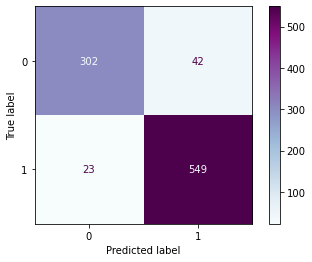

In [33]:
class_metrics(X_train, y_train, X_test,y_test, vote);

This is by far our best model ensemble learning has correctly classifed 1 more false positive, and 5 more false negatives than our logistic regression model which shows to me that our logistic regression model is doing the heavy lifing here. Since the logistic regressior is performing pretty well we have a good model that we can interpret. 

#### Lets look at coefficients.
Lets take a look into the coefficients of our model and see what determines a voter to vote democrat or republican, also lets look into what factors make up a moderate voter.

In [34]:
# Fit a Logistic Regression model with hyperparameters from voting classifer.
lr = LogisticRegression(max_iter=10_000, C=0.01, penalty='l2')
lr.fit(X_train, y_train);

In [35]:
# Create a dataframe that houses the Coefficients of the logistic model.
coeffs = pd.DataFrame(lr.coef_[0], index=X.columns, columns=['coeffs']).rename({'coeffs':'Coefficients'})

#Rename Title from Coeffs, to Coefficients.
coeffs.rename(columns={"coeffs": "coefficients"}, inplace=True)

#convert cofficeints to log odds.
coeffs['percent_odd'] = coeffs['coefficients'].map(lambda x : np.exp(x) - 1)

# Sort coefficients, by feature importances.
coeffs.sort_values(by= 'coefficients', ascending=False, inplace=True)

coeffs.iloc[:10]

,coefficients,percent_odd
ideo5_Liberal,0.664243,0.943019
approval_gov_Strongly Approve,0.617504,0.854294
ideo5_Very Liberal,0.565472,0.760278
race_Black,0.179883,0.197078
ownhome_Rent,0.137918,0.147882
ideo5_Not Sure,0.078473,0.081634
ideo5_Moderate,0.077715,0.080815
faminc_10k - 20k,0.069134,0.071580
educ_Some College,0.056625,0.058259
approval_gov_Never Heard / Not Sure,0.051226,0.052561


Here you can see the main factors that determine if someone will vote for the positive class democrat. These values are in log odds, we created another column to percent increase or decrease off odds. You can see from the above dataframe the top ten factors that increase the odds of the voter to vote for the democratic candidate. We see the usual suspects if the voter considers themselves liberal, and the predicessors aproval rating, the predicissior in this case is Jerry Brown, Gavin Neusem is his susccessor of the same party. Take note if the person consideres themselves black as opposed to asian, their odds of voting for the democratic cadidate increases by 20%. We also found that if you were a renter, as opposed the 'other' catagory your odds of voting for the democrat increase by 14%.

In [53]:
coeffs_con=coeffs.iloc[-10:]
coeffs_con.sort_values(by='coefficients', ascending=True)

,coefficients,percent_odd
approval_gov_Strongly Disapprove,-1.396247,-0.752476
pid3_Republican,-1.117950,-0.673051
ideo5_Very Conservative,-0.399013,-0.329018
pid3_Independent,-0.291938,-0.253185
approval_gov_Disapprove / Somewhat Disapprove,-0.244209,-0.216676
race_White,-0.179640,-0.164429
ownhome_Own,-0.151742,-0.140790
marstat_Married,-0.125181,-0.117662
pid3_Other,-0.112037,-0.105989
gender_Male,-0.095727,-0.091288


Looking at the chart above of our top 10 coeffients that predict the negative class "voting republican. Notice here that party affiliation has a stronger impact than ideology when voting Republican, which makes since because Republicans do vote acording party line, as oppose to those who vote Democrat who tend to be more ideological, and refraim for backing a party. We alos found that stong disapproval of the govenor, home ownership, and race being white aslo play an important role if the person will vote for the republican candidate.

#### Lets take a look at the moderates.
To determine who is a moderate we will use all the predictions from the logistic regression model where the predict probability was less than 60% for both positive and negative classes.

In [37]:
probas = pd.DataFrame(lr.predict_proba(X), index=X.index)
mod_index = probas[(probas[1] < .60) & (probas[0] < .60)]

# create a moderate dataframe from our original dataframe with
# just indexes from those with probability of either class
# under 65%
moderate_df = df_3.loc[mod_index.index]

These are the selct 301 that the model had lower than 60% probabality to classify, lets take a look into them and see their metrics.

In [38]:
moderate_df['voted_gov'].value_counts(normalize=True)

[Republican / Candidate 2]    0.644518
[Democrat / Candidate 1]      0.355482
Name: voted_gov, dtype: float64

In [39]:
moderate_df['ideo5'].value_counts(normalize=True)

Moderate             0.488372
Conservative         0.338870
Very Conservative    0.059801
Liberal              0.039867
Not Sure             0.039867
Very Liberal         0.033223
Name: ideo5, dtype: float64

In [40]:
moderate_df.columns

Index(['dist', 'ownhome', 'pid3', 'gender', 'age', 'educ', 'race', 'faminc',
       'marstat', 'newsint', 'approval_gov', 'ideo5', 'voted_gov'],
      dtype='object')

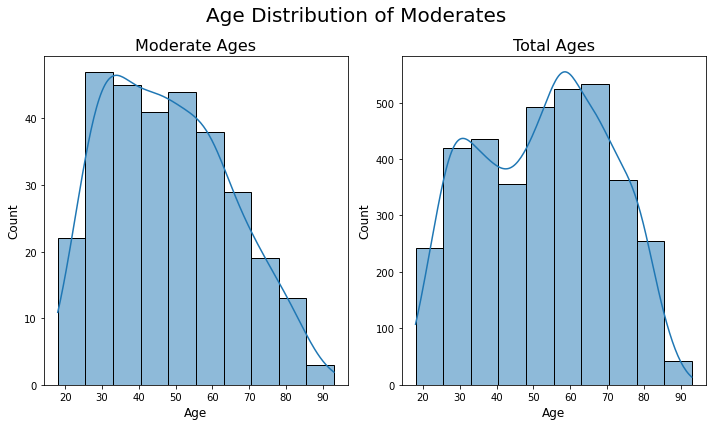

In [41]:
fig, ax = plt.subplots(
    1,
    2,
    figsize=(10,6),
    tight_layout=True,)

sns.histplot(data=moderate_df, x="age", ax=ax[0], bins=10, kde=True)
sns.histplot(data=df_3, x="age", ax=ax[1], bins=10, kde=True)

ax[0].set_xlabel('Age', fontsize=12)
ax[1].set_xlabel('Age', fontsize=12)

ax[0].set_ylabel('Count', fontsize=12)
ax[1].set_ylabel('Count', fontsize=12)

ax[0].set_title('Moderate Ages', fontsize=16)
ax[1].set_title('Total Ages', fontsize=16)
fig.suptitle('Age Distribution of Moderates', fontsize=20);

In [42]:
print('Mean Age of Voter sample', round(df_3['age'].mean(),2))
print('Mean Age of Moderates', round(moderate_df['age'].mean(),2))

Mean Age of Voter sample 52.38
Mean Age of Moderates 47.98


The mean Age of our "Moderates" is boardering close to our mean age of total sample

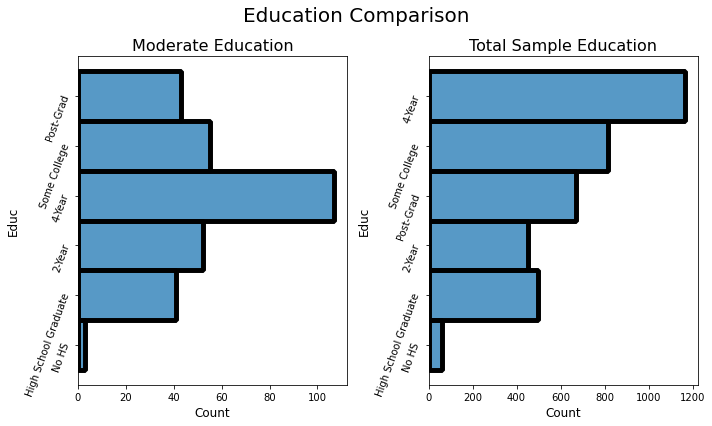

In [43]:
fig, ax = plt.subplots(
    1,
    2,
    figsize=(10,6),
    tight_layout=True,)

sns.histplot(data=moderate_df, y="educ", ax=ax[0])
sns.histplot(data=df_3, y="educ", ax=ax[1])

ax[0].set_xlabel('Count', fontsize=12)
ax[1].set_xlabel('Count', fontsize=12)

ax[0].set_ylabel('Educ', fontsize=12)
ax[1].set_ylabel('Educ', fontsize=12)

ax[0].set_title('Moderate Education', fontsize=16)
ax[1].set_title('Total Sample Education', fontsize=16)

ax[0].tick_params(axis='y', labelrotation = 70)
ax[1].tick_params(axis='y', labelrotation = 70)

fig.suptitle('Education Comparison', fontsize=20);

In [44]:
print('The most occouring catagory Total sample:', df_3.educ.mode()[0])
print('The most occouring catagory of moderates:', moderate_df.educ.mode()[0])

The most occouring catagory Total sample: 4-Year
The most occouring catagory of moderates: 4-Year


Again we can see that most of the moderates are again representing the most occouring class in this case. It looks to us that the voters that our model found difficult to classify are the ones whos basically sitting on top of the bellcurve they do not have many distingushing charataristics to separate them from the mean, causing our algorythem to have issues classifying the voter.

We will now dive into exploring the Random Forest classifer, in Modeling Notebook_2.